In [1]:
import sys
sys.path = ['../../../..'] + sys.path

In [2]:
import mlxtend
mlxtend.__version__

'0.3.0dev'

In [9]:
%load_ext watermark
%watermark -a 'Sebastian Raschka' -d -v -p scikit-learn

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Sebastian Raschka 10/19/2015 

CPython 3.5.0
IPython 4.0.0

scikit-learn 0.16.1


# Sequential Forward Selection

> from mlxtend.feature_selection import SFS

Sequential Forward Selection (SFS) is a classic feature selection algorithm -- a greedy search algorithm -- that has been developed as a suboptimal solution to the computationally often not feasible exhaustive search. In a nutshell, SFS adds one feature from the original feature set at the time, based on the classifier performance, until a feature subset of the desired size *k* is reached.


***Related topics:***

- [Sequential Backward Selection](./sequential_backward_selection.md)
- [Sequential Floating Forward Selection](./sequential_floating_forward_selection.md)
- [Sequential Floating Backward Selection](./sequential_floating_backward_selection.md)

---

### The SFFS Algorithm



**Input:** $Y = \{y_1, y_2, ..., y_d\}$  

- The ***SFS*** algorithm takes the whole $d$-dimensional feature set as input.


**Output:** $X_k = \{x_j \; | \;j = 1, 2, ..., k; \; x_j \in Y\}$, where $k = (0, 1, 2, ..., d)$

- SFS returns a subset of features; the number of selected features $k$, where $k < d$, has to be specified *a priori*.

**Initialization:** $X_0 = \emptyset$, $k = 0$

- We initialize the algorithm with an empty set $\emptyset$ ("null set") so that $k = 0$ (where $k$ is the size of the subset).

**Step 1 (Inclusion):**  

  $x^+ = \text{ arg max } J(x_k + x), \text{ where }  x \in Y - X_k$  
  $X_k+1 = X_k + x^+$  
  $k = k + 1$    
*Go to Step 2*

- in this step, we add an additional feature, $x^+$, to our feature subset $X_k$.
- $x^+$ is the feature that maximizes our criterion function, that is, the feature that is associated with the best classifier performance if it is added to $X_k$.

**Step 2 (Conditional Exclusion):**  

$x^- = \text{ arg max } J(x_k - x), \text{ where } x \in X_k$  
$if \; J(x_k - x) > J(x_k - x)$:    
&nbsp;&nbsp;&nbsp;&nbsp; $X_k-1 = X_k - x^-$  
&nbsp;&nbsp;&nbsp;&nbsp; $k = k - 1$    
*Go to Step 1*  

- In Step 2, we only remove a feature if the resulting subset would gain an increase in performance. We go back to Step 1.  
- Steps 1 and 2 are reapeated until the **Termination** criterion is reached.

**Termination:** $k = p$

- We add features from the feature subset $X_k$ until the feature subset of size $k$ contains the number of desired features $p$ that we specified *a priori*.

---

<br>
<br>

# Iris Example

In [5]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
from mlxtend.feature_selection import SFS
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import load_iris

iris = load_iris()
X = iris.data
y = iris.target

knn = KNeighborsClassifier(n_neighbors=4)

sfs = SFS(knn, k_features=2, scoring='accuracy', cv=5)
sfs.fit(X, y)

print('Indices of selected features:', sfs.indices_)
print('CV score of selected subset:', sfs.k_score_)
print('New feature subset:')
sfs.transform(X)[0:5]

Features: 2/2

Indices of selected features: (2, 3)
CV score of selected subset: 0.966666666667
New feature subset:


array([[ 1.4,  0.2],
       [ 1.4,  0.2],
       [ 1.3,  0.2],
       [ 1.5,  0.2],
       [ 1.4,  0.2]])

<br>
<br>

# Wine Data Example

In [7]:
import pandas as pd

df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data', header=None)

X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


Features: 13/13

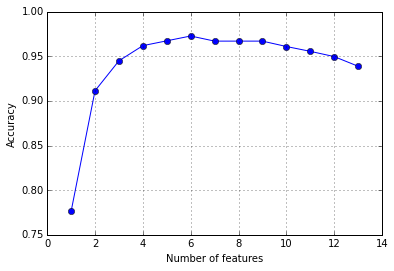

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

scr = StandardScaler()
X_std = scr.fit_transform(X)

knn = KNeighborsClassifier(n_neighbors=4)

# selecting features
sfs = SFS(knn, k_features=13, scoring='accuracy', cv=5)
sfs.fit(X_std, y)

# plotting performance of feature subsets
k_feat = [len(k) for k in sfs.subsets_]

plt.plot(k_feat, sfs.scores_, marker='o')
plt.ylabel('Accuracy')
plt.xlabel('Number of features')
plt.grid()
plt.show()

<br>
<br>

# Gridsearch Example 1

Selecting the number of features in a pipeline.

In [9]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV
from mlxtend.feature_selection import SFS
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_iris

##########################
### Loading data
##########################

iris = load_iris()
X = iris.data
y = iris.target

##########################
### Setting up pipeline
##########################
knn = KNeighborsClassifier(n_neighbors=4)

sfs = SFS(estimator=knn, k_features=2, scoring='accuracy', cv=5)

pipeline = Pipeline([
            ('scr', StandardScaler()), 
            ('sel', sfs),
            ('clf', knn)])

parameters = {'sel__k_features': [1,2,3,4]}

grid_search = GridSearchCV(pipeline, parameters, n_jobs=1, verbose=1)

##########################
### Running GridSearch
##########################
grid_search.fit(X, y)

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Features: 1/1[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.0s
Features: 4/4[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    1.1s finished
Features: 1/1

Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best score: 0.960
Best parameters set:
	sel__k_features: 1


<br>
<br>

# Gridsearch Example 2

Tuning the estimator used for feature selection. Note that the current implementation requires to search for the weights in both the classifier and the SBS transformer separately.

In [10]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV
from mlxtend.feature_selection import SFS
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_iris

##########################
### Loading data
##########################

iris = load_iris()
X = iris.data
y = iris.target

##########################
### Setting up pipeline
##########################
knn = KNeighborsClassifier(n_neighbors=4)

sfs = SFS(estimator=knn, k_features=2, scoring='accuracy', cv=5)

pipeline = Pipeline([
            ('scr', StandardScaler()), 
            ('sel', sfs),
            ('clf', knn)])

parameters = {'sel__k_features': [1, 2, 3, 4],
              'sel__estimator__n_neighbors': [4, 5, 6],
              'clf__n_neighbors': [4, 5, 6]}

grid_search = GridSearchCV(pipeline, parameters, n_jobs=1, verbose=1)

##########################
### Running GridSearch
##########################
grid_search.fit(X, y)

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Features: 1/1[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.0s
Features: 1/1[Parallel(n_jobs=1)]: Done  50 jobs       | elapsed:    4.6s
Features: 4/4[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:   10.2s finished
Features: 2/2

Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best score: 0.973
Best parameters set:
	clf__n_neighbors: 5
	sel__estimator__n_neighbors: 5
	sel__k_features: 2


The final feature subset can then be obtained as follows:

In [11]:
print('Best feature subset:')
grid_search.best_estimator_.steps[1][1].indices_

Best feature subset:


(2, 3)

# API

In [23]:
from mlxtend.feature_selection import SFS
help(SFS)

Help on class SFS in module mlxtend.feature_selection.sequential_forward_select:

class SFS(sklearn.base.BaseEstimator, sklearn.base.MetaEstimatorMixin)
 |  Sequential Forward Selection for feature selection.
 |  
 |  Parameters
 |  ----------
 |  estimator : scikit-learn estimator object
 |  
 |  print_progress : bool (default: True)
 |     Prints progress as the number of epochs
 |     to stderr.
 |  
 |  k_features : int
 |    Number of features to select where k_features.
 |  
 |  scoring : str, (default='accuracy')
 |    Scoring metric for the cross validation scorer.
 |  
 |  cv : int (default: 5)
 |    Number of folds in StratifiedKFold.
 |  
 |  n_jobs : int (default: 1)
 |    The number of CPUs to use for cross validation. -1 means 'all CPUs'.
 |  
 |  Attributes
 |  ----------
 |  indices_ : array-like, shape = [n_predictions]
 |    Indices of the selected subsets.
 |  
 |  k_score_ : float
 |    Cross validation mean score of the selected subset
 |  
 |  subsets_ : list of t